# Семинар 5: взрыв и затухание градиента

В этой тетрадке мы немного поэкспериментируем с затухающими и взрывающимися градиентами. Делать это будем на уже знакомом нам датасете fashoin MNIST. 

В этом разделе мы не будем пытаться подобрать более удачную архитектуру, нам интересно только посмотреть на особенности обучения глубоких сетей.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
tf.__version__ 

'2.8.0'

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train.shape, X_test.shape

4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

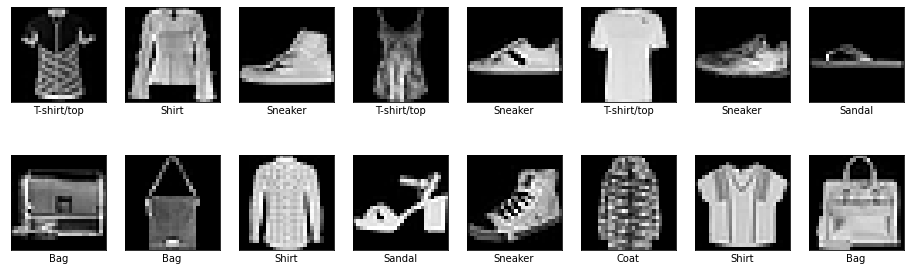

In [4]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

In [5]:
X_train.max()/2

127.5

In [6]:
X_train = X_train/127.5 - 1
X_test = X_test/127.5 - 1

In [7]:
X_train.min(), X_train.max()

(-1.0, 1.0)

Для экспериментов нам понадобится реализовать сеть, в которой можно легко менять количество слоев. Также эта сеть должна сохранять градиенты на всех слоях, чтобы потом мы могли посмотреть на их величины.

**Задание 1:** допишите недостающую часть кода ниже.

In [38]:
X_train[0].shape

(28, 28)

In [45]:
from tensorflow.keras import Model, layers, Sequential
import tensorflow.keras.optimizers as opt

class DeepDenseNet(Model):
    def __init__(self, activation, k):
        super().__init__()
        self.activation = activation
        self.units = k
        self.nn_layers = [layers.Flatten()]
        while k > 16:
            self.nn_layers.append(layers.Dense(k, activation=activation))
            k = k // 2

        self.nn_layers.append(layers.Dense(10, activation='softmax'))
        self.seq = Sequential(self.nn_layers)
        
    def call(self, x):
        out = self.seq(x)
        return out

Напишите функции обучения так, чтобы они рисовали графики изменения градиентов и траектории обучения.

In [34]:
model = DeepDenseNet('sigmoid', 2048)

In [35]:
model(X_train[:2])

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.25747958, 0.04154446, 0.10088023, 0.02238228, 0.03311049,
        0.15796676, 0.07958346, 0.03383782, 0.18716322, 0.08605181],
       [0.25749627, 0.04154279, 0.10087848, 0.02238191, 0.03311251,
        0.15798281, 0.07957356, 0.03383774, 0.18713664, 0.08605731]],
      dtype=float32)>

In [46]:
model.compile(opt.Adam(), 'sparse_cross_entropy')
model.fit(X_train, y_train, epochs=1, verbose=1)

1875/1875 [==============================] - 75s 39ms/step - loss: 27.6101


In [53]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(10000).batch(256)
test_ds = test_ds.batch(256)

In [54]:
learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

In [78]:
from tqdm.notebook import tqdm

@tf.function
def train_step(images, labels, model):
    
    # находим loss и пробрасываем градиент
    with tf.GradientTape() as t:
        pred = model.call(images)
        loss = loss_function(labels, pred)
        
    # Вычисляем градиенты и обновляем веса
    gr = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gr, model.trainable_variables))
    
    return gr

def train_model(train_ds, X_test, y_test, model, EPOCHS=1):

    total_grad = [ ]
    losses = [ ]
    for images, labels in tqdm(train_ds):
        g = train_step(images, labels, model)
        total_grad.append(g)
        losses.append(loss_function(y_test, model(X_test)))
        
    return total_grad, losses

In [79]:
model_s = DeepDenseNet('sigmoid', 2048)
grad, loss = train_model(train_ds, X_test, y_test, model_s)

  0%|          | 0/235 [00:00<?, ?it/s]

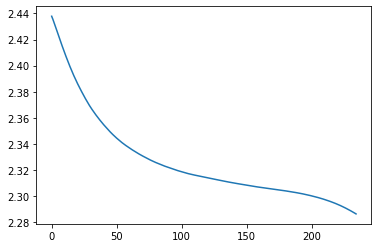

In [80]:
plt.plot(loss)

In [84]:
H = np.array([[np.abs(jtem.numpy()).sum() for jtem in ktem] for ktem in grad])
H

array([[4.64018166e-01, 7.37612601e-04, 2.02380538e+00, ...,
        2.44279757e-01, 6.41214275e+00, 4.22999978e-01],
       [5.30638874e-01, 9.16309364e-04, 2.47068453e+00, ...,
        2.81142324e-01, 7.42369795e+00, 4.90245938e-01],
       [5.35238326e-01, 9.92876478e-04, 2.69065642e+00, ...,
        3.14443171e-01, 6.50472498e+00, 4.30092633e-01],
       ...,
       [3.76841158e-01, 2.11865452e-04, 6.91420078e-01, ...,
        5.20742275e-02, 1.46329832e+00, 1.11771546e-01],
       [4.48279172e-01, 3.08770221e-04, 6.53852642e-01, ...,
        5.04380465e-02, 1.59589267e+00, 1.20616056e-01],
       [5.04244149e-01, 6.89131441e-04, 8.84219289e-01, ...,
        7.58263916e-02, 2.15388584e+00, 1.65543899e-01]], dtype=float32)

In [85]:
H.shape

(235, 16)

In [89]:
import pandas as pd 
df = pd.DataFrame(H)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.464018,0.000738,2.023805,0.001941,2.694500,0.005210,3.605252,0.013831,4.965524,0.037835,6.306372,0.097354,7.925475,0.244280,6.412143,0.423000
1,0.530639,0.000916,2.470685,0.002378,3.360002,0.006498,4.425563,0.016967,5.830120,0.044402,7.202214,0.111209,9.123548,0.281142,7.423698,0.490246
2,0.535238,0.000993,2.690656,0.002604,3.597601,0.006959,4.878550,0.018701,6.521322,0.049629,8.025184,0.123984,10.207394,0.314443,6.504725,0.430093
3,0.464758,0.000667,1.839834,0.001758,2.402057,0.004640,3.265006,0.012498,4.475728,0.034035,5.754822,0.088962,7.327559,0.225687,6.537101,0.432828
4,0.516189,0.000896,2.438177,0.002353,3.230169,0.006238,4.330927,0.016576,5.959569,0.045282,7.430656,0.114926,8.944958,0.275452,6.934938,0.459847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0.548615,0.001143,0.814866,0.000691,1.016760,0.001428,1.478200,0.003582,1.529009,0.007137,1.726266,0.021285,2.672005,0.073666,2.129895,0.163088
231,0.455614,0.000776,0.725748,0.000592,1.009632,0.001493,1.542725,0.004222,1.752041,0.009380,2.172156,0.029208,3.330904,0.092776,2.714578,0.208176
232,0.376841,0.000212,0.691420,0.000411,1.048339,0.001267,1.549749,0.003164,1.495985,0.005629,1.428697,0.014446,1.919164,0.052074,1.463298,0.111772
233,0.448279,0.000309,0.653853,0.000350,0.945793,0.001075,1.418274,0.002896,1.407622,0.005376,1.371730,0.014290,1.945156,0.050438,1.595893,0.120616


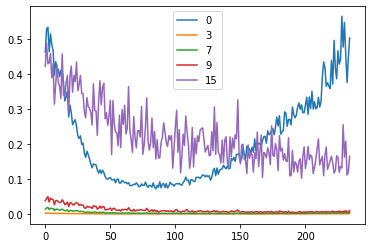

In [91]:
df[[0,3,7,9,15]].plot()

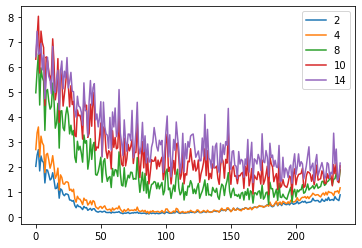

In [92]:
df[[2,4,8,10,14]].plot()

**Задание 2:**
* Обучите сети глубины 10 и больше с сигмоидой в качестве активации. Исследуйте, как глубина влияет на качество обучения и поведение градиентов на далеких от выхода слоях.
* Теперь замените активацию на ReLU и посмотрите, что получится.

Теперь попробуем добавить в сеть skip-connections (по примеру ResNet) вместо замены сигмоиды на relu и посмотрим, что получится. Запихнуть все слои в nn.Sequential и просто их применить теперь не получится - вместо этого мы их применим вручную.

**Задание 3:** допишите недостающую часть кода ниже.

In [ ]:
inp 
h = FC1(inp)
h = FC2(inp) 
h1 = inp + h
h = FC3(h1) 
h = FC4(h)
h1 = h1 + h
h = FC5(h1) 
h = FC6(h)
h1 = h1 + h

In [ ]:
class DeepDenseResNet(Model):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        # <your code here>
        
    def call(self, x):
        
        # <your code here>
        
        return out

Убедимся, что такая сеть отлично учится даже на большом числе слоев.

In [ ]:
model = DeepDenseResNet(n_layers=20, hidden_size=10, activation=nn.Sigmoid)
# <your code here>